In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.formula.api as sfa
import statsmodels.api as sma

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import KFold,LeaveOneOut,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE,RFECV
from mlxtend.feature_selection import SequentialFeatureSelector
    
from statsmodels.stats.diagnostic import linear_rainbow

import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('Concrete_Data.csv')

In [3]:
data

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


# ML Pipeline
### 1. Data Preprocessing
#### (i) Collection
#### (ii) Format
#### (iii) Treat Anomalies

### 2. Feature Extraction
#### (i) Feature Transformation
#### (ii) Feature Engineering
#### (iii) Feature selection
#### (iv) Stepwize feature selection(SFS)
#### (v) Resursive Feature elimination(RFE)

### 3. Modeling
#### (i) Model Building
#### (ii) Model Evaluation
#### (iii) Train test data
#### (iv) Scores (R2,Adj R2)
#### (v) Error (MSE,RMSE,MAE,MAPE)


### 4.  Optimization
#### (i) Bais & Variance Trade off
#### (ii) Model validation techniques
#### (iii) k-Fold cross validation
#### (iv) LOOCV(Leave one out CV)
#### (v) Fine Tunning

In [4]:
# Descriptive Analysis of the data
print('Number of rows:',data.shape[0])
print('Number of columns:',data.shape[1])

Number of rows: 1030
Number of columns: 9


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
Blast Furnace Slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
Fly Ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
Water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
Superplasticizer,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
Coarse Aggregate,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
Fine Aggregate,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
Age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
Concrete compressive strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


<Axes: >

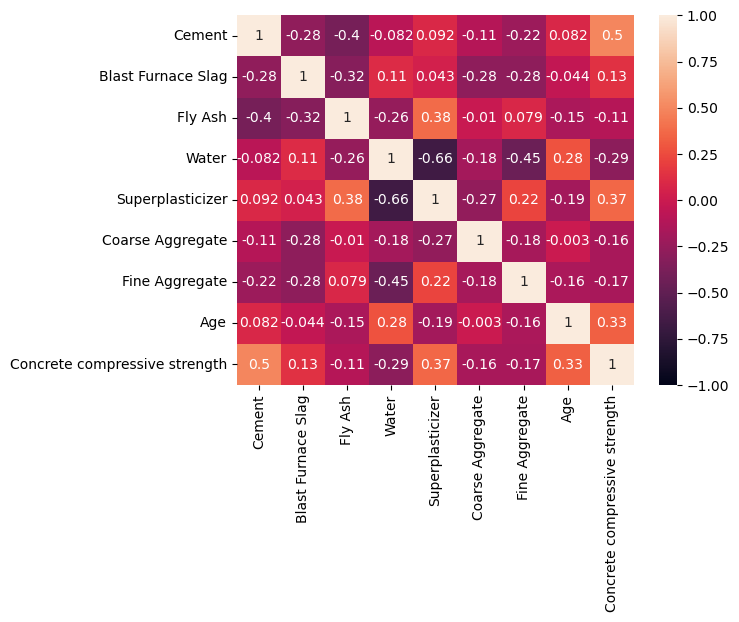

In [6]:
# Cov heat map
sns.heatmap(data.corr(),annot=True,vmin=-1,vmax=1)

In [7]:
# We have Identified some duplicated rows in the dataset
data.duplicated().sum()

25

In [8]:
data.drop_duplicates(inplace=True)

In [9]:
data.duplicated().sum()

0

### Univariate and Bivariante Analysis

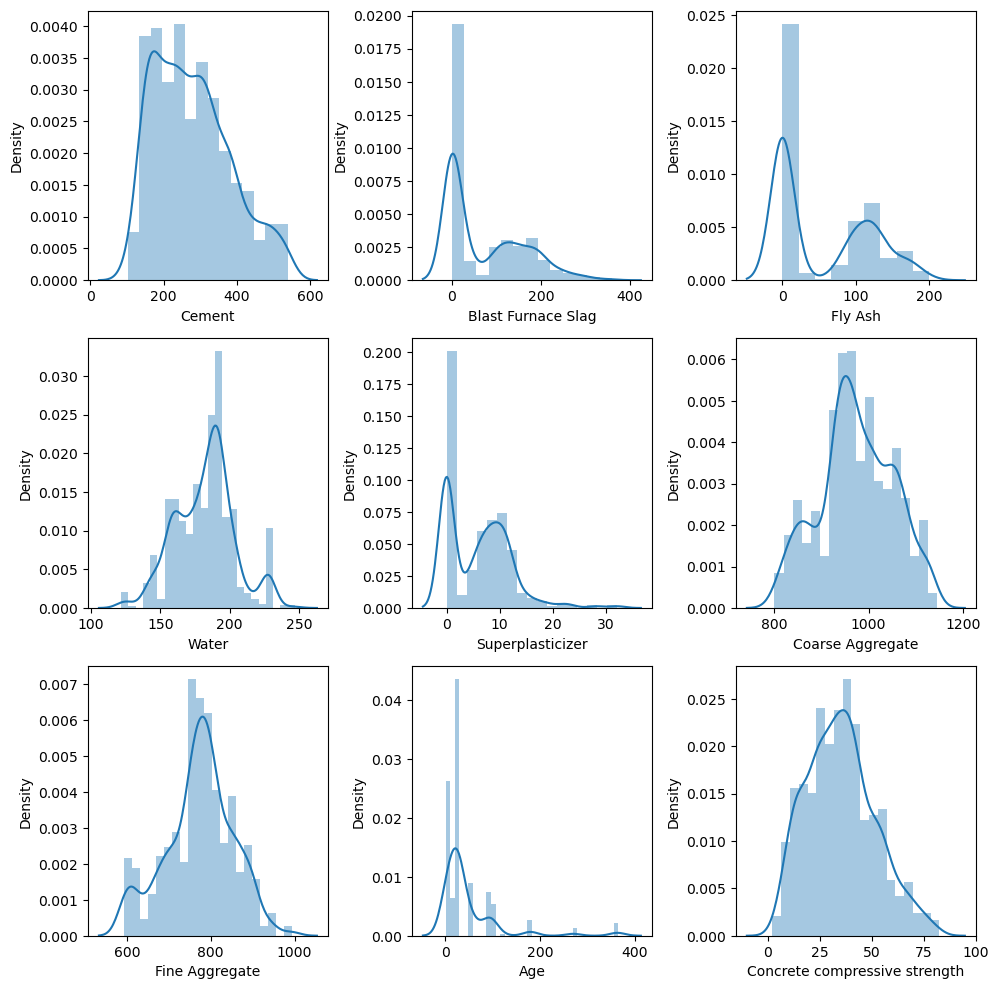

In [10]:
plt.figure(figsize=(10,10))

t=1
for i in data.columns:
    plt.subplot(3,3,t)
    sns.distplot(data[i])
    t+=1
plt.tight_layout()
plt.show()

In [11]:
data.rename(columns={'Concrete compressive strength':'CCS'},inplace=True)

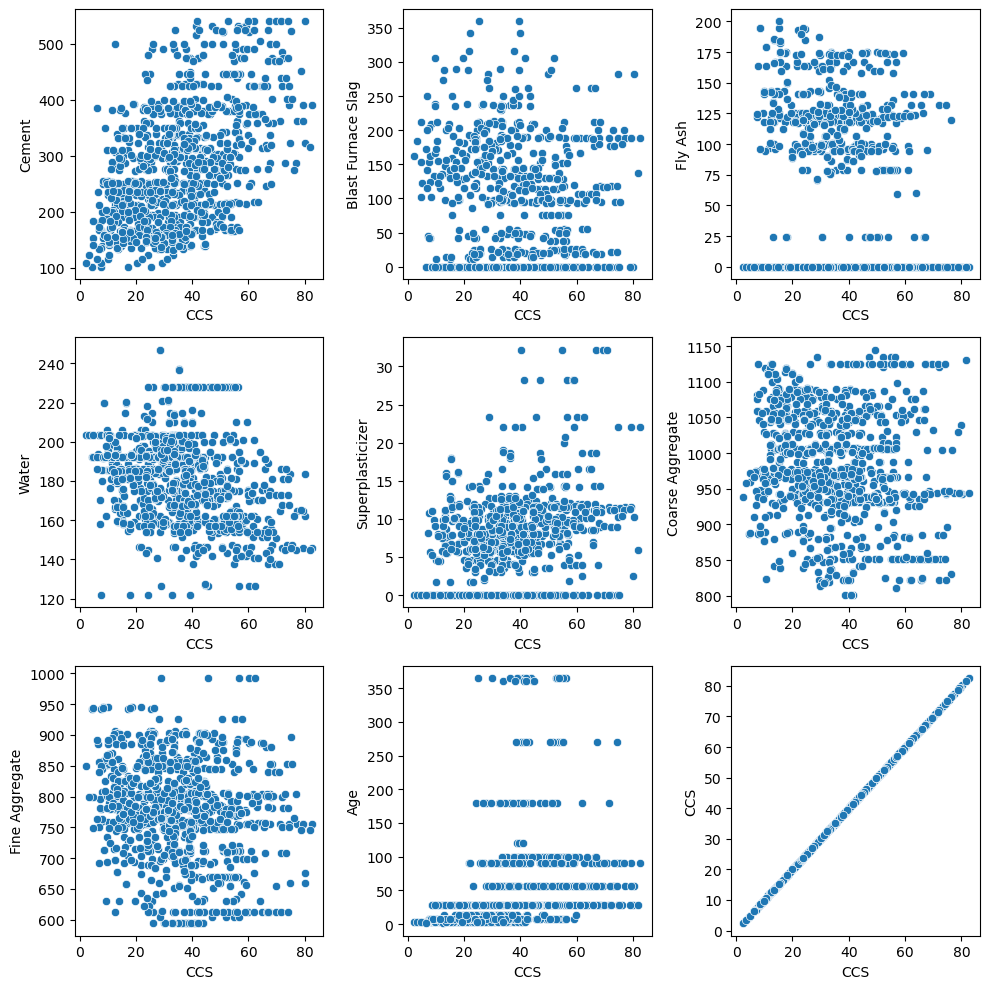

In [12]:
plt.figure(figsize=(10,10))
t=1
for i in data.columns:
    plt.subplot(3,3,t)
    sns.scatterplot(y=data[i],x=data['CCS'])
    t+=1
plt.tight_layout()
plt.show()

In [13]:
# Treat anoompliers(missing value and outliers)
data.isnull().sum()

Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
CCS                   0
dtype: int64

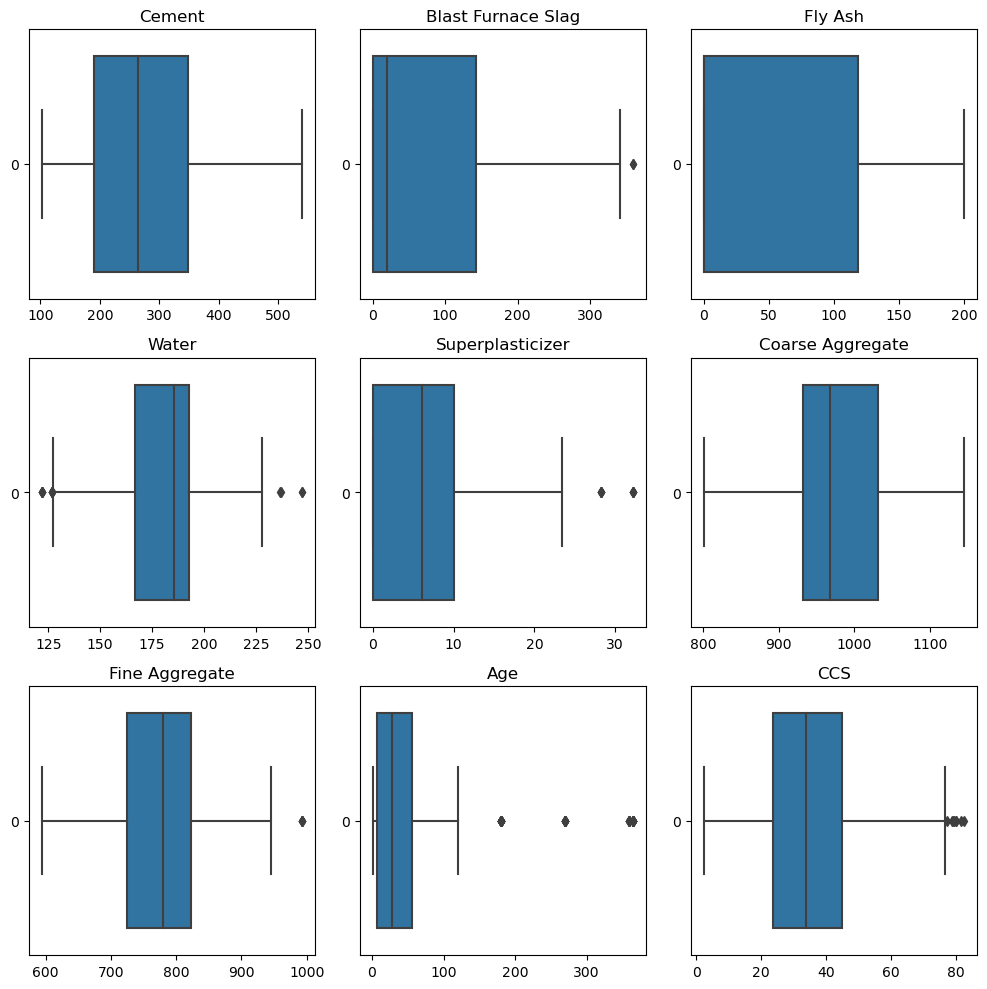

In [14]:
plt.figure(figsize=(10,10))

t=1
for i in data.columns:
    plt.subplot(3,3,t)
    sns.boxplot(data[i],orient='h')
    plt.title(i)
    t+=1
plt.tight_layout()
plt.show()

In [15]:
# since water and cement has high colliniearity lets take cement to water ratio

data['Cement water ratio']=data['Cement']/data['Water']
data.drop(columns=['Cement','Water'],inplace=True)

data['Course Fine ratio']=data['Coarse Aggregate']/data['Fine Aggregate']
data.drop(columns=['Coarse Aggregate','Fine Aggregate'],inplace=True)

data.drop(columns=['Course Fine ratio'],inplace=True)

In [16]:
data.head()

,Blast Furnace Slag,Fly Ash,Superplasticizer,Age,CCS,Cement water ratio
0,0.0,0.0,2.5,28,79.99,3.333333
1,0.0,0.0,2.5,28,61.89,3.333333
2,142.5,0.0,0.0,270,40.27,1.458333
3,142.5,0.0,0.0,365,41.05,1.458333
4,132.4,0.0,0.0,360,44.30,1.034375


In [17]:
# Train test split
x=data.drop(columns=['CCS'])
y=data['CCS']
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.75,random_state=2)

In [18]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(753, 5) (753,) (252, 5) (252,)


### Feature Extraction

**Why do we need feature transformation**
1. In case of skewed variable,we transform it to reduce the skewness
2. If assumptions of LR are not met, Transformation of skewes target variable will help making the error term more compatible to the assumption
3. It will transformation the non linear relation between the target and independent variale to a linear relation. Assumption of linearity or normality

**Note: Comparision of model performance should be done using original unit for the target variable and not units after transformation**

**Feature Scalling: We do not scale the feature to have correct factors or slope for independent variable. This usually done for distance  based model algorithms/Models**

### Modeling

In [19]:
# Check for the assumptions 
# 1. Target must be numeric

In [20]:
vif_list=[]

for i in range(x_train.shape[1]):
    vif_list.append(variance_inflation_factor(x_train.values,i))

In [21]:
# Check for multicollinearity
vif_list=[]

for i in range(x_train.shape[1]):
    vif_list.append(variance_inflation_factor(x_train.values,i))
    
pd.DataFrame({"Feature Names":x_train.columns,'VIF':vif_list}).sort_values(by="VIF",ascending=False)

,Feature Names,VIF
2,Superplasticizer,3.164567
4,Cement water ratio,2.921064
1,Fly Ash,1.869333
3,Age,1.467144
0,Blast Furnace Slag,1.452220


In [22]:
# Lets Built a base model
x_train_c=sma.add_constant(x_train)
x_test_c=sma.add_constant(x_test)

base_model=sma.OLS(y_train,x_train_c).fit()
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CCS   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     221.4
Date:                Tue, 23 Jan 2024   Prob (F-statistic):          8.90e-145
Time:                        13:07:12   Log-Likelihood:                -2833.1
No. Observations:                 753   AIC:                             5678.
Df Residuals:                     747   BIC:                             5706.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -11.1731      1.805     -6.191      0.000     -14.716      -7.630
Blast Furnace Slag     0.0820      0.006     14.118      0.000       0.071       0.093
Fly Ash                0.0856      0.009      9.250      0.000       0.067       0.104
Superplasticizer       0.1808      0.090      2.017      0.044       0.005       0.357
Age                    0.1005      0.006     17.660      0.000       0.089       0.112
Cement water ratio    19.2583      0.876     21.978      0.000      17.538      20.978
==============================================================================
Omnibus:                        0.703   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.704   Jarque-Bera (JB):                0.796
Skew:                          -0.045   Prob(JB):                        0.672
Kurtosis:                       2.868   Cond. No.                         633.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
# Assumption: Linearity of model

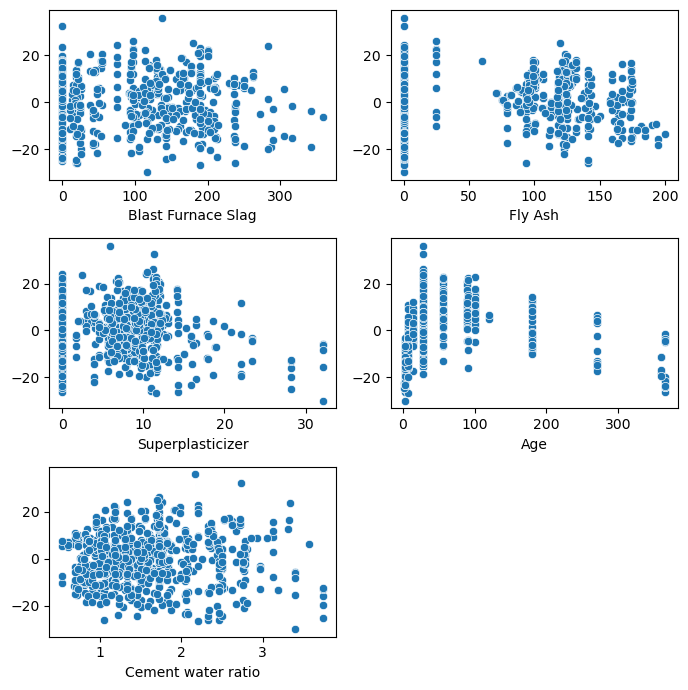

In [24]:
plt.figure(figsize=(7,7))
t=1
for i in x_train.columns:
    plt.subplot(3,2,t)
    sns.scatterplot(x=x_train[i],y=base_model.resid)
    t+=1
plt.tight_layout()
plt.show()

In [25]:
# Ho: variables are linear
# Ha: variables are not linear

p_val=linear_rainbow(base_model)[1]
print('P_value:',p_val)

if p_val<0.05:
    print('Reject the null hypo')
else:
    print('Fail to reject the null hypo')

P_value: 0.7241792494932411
Fail to reject the null hypo


In [26]:
# assumption of Autocorrelation

# Durbin Watson = 1.999 show there is no autocorrelation

In [27]:
# Assumption of Homoskedasiticty

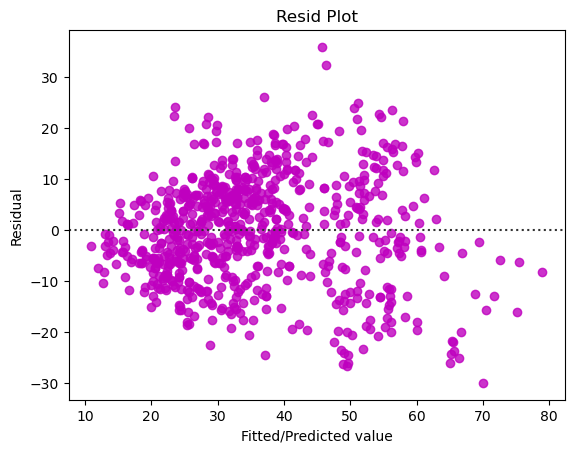

In [28]:
# Residual plot
sns.residplot(x=base_model.fittedvalues,y=base_model.resid,color='m')
plt.xlabel('Fitted/Predicted value')
plt.ylabel('Residual')
plt.title('Resid Plot')
plt.show()

In [29]:
# Goldfetd Quandt Test

# Ho: The variance is same: Homoskedastic
# Ha: The variance is not same: Hetroskedastic

p_value=sma.stats.diagnostic.het_goldfeldquandt(x=x_train_c,y=y_train,drop=0.1,alternative='two-sided')[1]

if p_value<0.05:
    print('Reject Ho')
else:
    print('Fail to reject Ho')

Fail to reject Ho


In [30]:
# Breusch Pagan test

# Ho: The variance is same: Homoskedastic
# Ha: The variance is not same: Homoskedastic

p_value=sma.stats.diagnostic.het_breuschpagan(resid=base_model.resid,exog_het=base_model.model.exog)[1]

if p_value<0.05:
    print('Reject Ho')
else:
    print('Fail to reject Ho')

Reject Ho


In [31]:
# Assumption for normality  

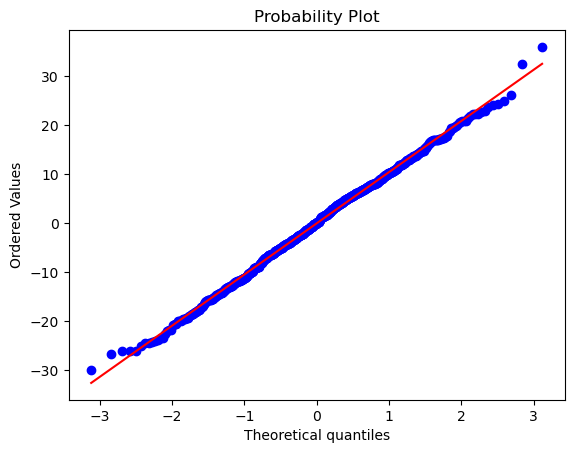

In [32]:
# QQ plot
stats.probplot(base_model.resid,plot=plt)
plt.show()

In [33]:
# Shapiro-Wilk Test   (Number of rows<5000)

# Ho: The data is norma
# Ha: The data is not normal

p_value=stats.shapiro(base_model.resid)[1]

print('p_value:',p_value)
if p_value<0.05:
    print('Reject Ho')
else:
    print('Fail to reject Ho')

p_value: 0.48371803760528564
Fail to reject Ho


### Model Evaluation

In [34]:
def validation (test,pred,data):
    r2=r2_score(test,pred)
    print('R Squared: ',r2)
    n=data.shape[0]
    k=data.shape[1]
    r2_adj=1-((1-r2)*(n-1)/(n-k-1))
    print('Adj R Square: ',r2_adj)
    print('MSE: ',mean_squared_error(test,pred))
    print('RMSE: ',np.sqrt(mean_squared_error(test,pred)))
    print('MAE: ',mean_absolute_error(test,pred))
    print('MAPE: ',mean_absolute_percentage_error(test,pred))

In [35]:
pred_train=base_model.predict(x_train_c)

In [36]:
validation(y_train,pred_train,x_train_c)

R Squared:  0.5970851441472325
Adj R Square:  0.5965486396787201
MSE:  108.53226979306346
RMSE:  10.417882212477902
MAE:  8.406751938564085
MAPE:  0.3233153654583724


In [37]:
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CCS   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     221.4
Date:                Tue, 23 Jan 2024   Prob (F-statistic):          8.90e-145
Time:                        13:07:13   Log-Likelihood:                -2833.1
No. Observations:                 753   AIC:                             5678.
Df Residuals:                     747   BIC:                             5706.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -11.1731      1.805     -6.191      0.000     -14.716      -7.630
Blast Furnace Slag     0.0820      0.006     14.118      0.000       0.071       0.093
Fly Ash                0.0856      0.009      9.250      0.000       0.067       0.104
Superplasticizer       0.1808      0.090      2.017      0.044       0.005       0.357
Age                    0.1005      0.006     17.660      0.000       0.089       0.112
Cement water ratio    19.2583      0.876     21.978      0.000      17.538      20.978
==============================================================================
Omnibus:                        0.703   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.704   Jarque-Bera (JB):                0.796
Skew:                          -0.045   Prob(JB):                        0.672
Kurtosis:                       2.868   Cond. No.                         633.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
pred_test=base_model.predict(x_test_c)

In [39]:
validation(y_test,pred_test,x_test_c)

R Squared:  0.5670892212984766
Adj R Square:  0.5653575781836705
MSE:  108.6692559329714
RMSE:  10.424454706744685
MAE:  8.355986702524971
MAPE:  0.3410804302758667


### Cross Validation

In [40]:
# K-fold CV

In [41]:
lr=LinearRegression()

cv_score=cross_val_score(estimator=lr,X=x,y=y,cv=3,scoring='r2')

In [42]:
cv_score

array([0.45021923, 0.5321347 , 0.57753016])

In [43]:
print('Avg R2',np.mean(cv_score),'Variance in R2',np.std(cv_score)/np.mean(cv_score))

Avg R2 0.5199613635610226 Variance in R2 0.10131993012055238


In [44]:
# LOOCV
lr=LinearRegression()
# cross_val=LeaveOneOut()

cv_score=cross_val_score(estimator=lr,X=x,y=y,cv=LeaveOneOut(),scoring='neg_mean_absolute_percentage_error')

In [45]:
cv_score

array([-0.3065317 , -0.10004584, -0.44071529, ..., -0.18257283,
       -0.17196701, -0.02006925])

In [46]:
np.abs(np.mean(cv_score))

0.3276987592860946

### Feature Selection

In [47]:
x

,Blast Furnace Slag,Fly Ash,Superplasticizer,Age,Cement water ratio
0,0.0,0.0,2.5,28,3.333333
1,0.0,0.0,2.5,28,3.333333
2,142.5,0.0,0.0,270,1.458333
3,142.5,0.0,0.0,365,1.458333
4,132.4,0.0,0.0,360,1.034375
...,...,...,...,...,...
1025,116.0,90.3,8.9,28,1.538976
1026,0.0,115.6,10.4,28,1.643878
1027,139.4,108.6,6.1,28,0.770628
1028,186.7,0.0,11.3,28,0.906036


### SFS(Forward and Backward)

In [48]:
sfs=SequentialFeatureSelector(estimator=lr,k_features=4,scoring='r2',cv=3)

In [49]:
sfs.fit(x_train,y_train)

SequentialFeatureSelector(cv=3, estimator=LinearRegression(), k_features=(4, 4),
                          scoring='r2')

In [50]:
sfs.k_feature_names_

('Blast Furnace Slag', 'Superplasticizer', 'Age', 'Cement water ratio')

In [51]:
sfs.k_score_

0.5445300897085735

In [52]:
testx=x_test[['Blast Furnace Slag', 'Superplasticizer', 'Age', 'Cement water ratio']]
trainx=x_train[['Blast Furnace Slag', 'Superplasticizer', 'Age', 'Cement water ratio']]

In [53]:
lr=LinearRegression()

In [54]:
lr.fit(trainx,y_train)

LinearRegression()

In [55]:
pred_test=lr.predict(testx)

In [56]:
validation(y_test,pred_test,testx)

R Squared:  0.5624137492398523
Adj R Square:  0.5606634042368117
MSE:  109.84289284557045
RMSE:  10.48059601576029
MAE:  8.273738470425654
MAPE:  0.3477963666739815


In [57]:
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CCS   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     221.4
Date:                Tue, 23 Jan 2024   Prob (F-statistic):          8.90e-145
Time:                        13:07:14   Log-Likelihood:                -2833.1
No. Observations:                 753   AIC:                             5678.
Df Residuals:                     747   BIC:                             5706.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -11.1731      1.805     -6.191      0.000     -14.716      -7.630
Blast Furnace Slag     0.0820      0.006     14.118      0.000       0.071       0.093
Fly Ash                0.0856      0.009      9.250      0.000       0.067       0.104
Superplasticizer       0.1808      0.090      2.017      0.044       0.005       0.357
Age                    0.1005      0.006     17.660      0.000       0.089       0.112
Cement water ratio    19.2583      0.876     21.978      0.000      17.538      20.978
==============================================================================
Omnibus:                        0.703   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.704   Jarque-Bera (JB):                0.796
Skew:                          -0.045   Prob(JB):                        0.672
Kurtosis:                       2.868   Cond. No.                         633.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
base_model.pvalues.sort_values()

Cement water ratio    5.890486e-83
Age                   1.362635e-58
Blast Furnace Slag    2.722845e-40
Fly Ash               2.311530e-19
const                 9.852347e-10
Superplasticizer      4.402621e-02
dtype: float64

### RFE

In [59]:
base_model.params

const                -11.173110
Blast Furnace Slag     0.081975
Fly Ash                0.085565
Superplasticizer       0.180758
Age                    0.100494
Cement water ratio    19.258256
dtype: float64

In [60]:
rfe=RFE(estimator=lr,n_features_to_select=4,step=1)

In [61]:
rfe.fit(x_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=4)

In [62]:
rfe.get_feature_names_out()

array(['Fly Ash', 'Superplasticizer', 'Age', 'Cement water ratio'],
      dtype=object)

In [63]:
pred_train=rfe.predict(x_test)

In [64]:
validation(y_test,pred_test,x_test)

R Squared:  0.5624137492398523
Adj R Square:  0.5606634042368117
MSE:  109.84289284557045
RMSE:  10.48059601576029
MAE:  8.273738470425654
MAPE:  0.3477963666739815


In [65]:
rfecv=RFECV(estimator=lr)

In [66]:
rfecv.fit(x_train,y_train)

RFECV(estimator=LinearRegression())

In [67]:
rfecv.get_feature_names_out()

array(['Blast Furnace Slag', 'Fly Ash', 'Superplasticizer', 'Age',
       'Cement water ratio'], dtype=object)

In [68]:
rfecv.score(x_test,y_test)

0.5670892212984706